In [1]:
from sympy import *
from sympy import init_printing
init_printing()
def ll(a, b):
    return (a*b) / (a + b)

In [2]:
# Problem 2: Resistance looking into drain of source-degenerated NMOS (re-derivation as a test)
i1,i2,i3 = symbols("i1 i2 i3")
vtest, vs, gm, Rs, ro, itest = symbols("v_{test} V_s g_m R_s r_o, i_{test}")
sol = nonlinsolve([
    i1 + i2 - i3,
    itest + i1 + i2,
    i2 - (vtest - vs)/ro,
    i1 + gm*vs,
    i3 - vs/Rs
], [i1, i2, i3, vtest, vs, itest])
itest = sol.args[0][5]
rout = vtest / -itest
display(rout.simplify())

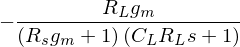

In [3]:
# Problem 2a: Naive Gain of CS-amp with degeneration and complex R_L || C_L load (ignoring C_gs)
s, RL, CL = symbols("s R_L C_L")
ZL = RL / (1 + s*RL*CL)
av = - (gm * ZL) / (1 + gm*Rs)
display(av.simplify())

In [4]:
# Problem 2a: Proper gain derivation (considering C_gs)
def derive_cs_gain():
    s, RL, CL, ZL, Cgs, Rs, gm = symbols("s R_L C_L Z_L C_{gs} R_s g_m")
    igate, isource, idrain = symbols("i_g i_s i_d")
    vs, vd, vi = symbols("v_s v_d v_i")
    sol = nonlinsolve([
        igate - ((vi - vs) / (1 / (s*Cgs))),
        isource - (vs / Rs),
        idrain - gm*(vi - vs),
        -vd - idrain*ZL,
        isource - igate - idrain
    ], [igate, isource, idrain, vd, vs])
    vd_sol = sol.args[0][3]
    gain = vd_sol / vi
    ZL_sol = ll(CL, RL)
    ZL_sol = ZL_sol.subs(CL, (1 / (s*CL))).simplify()
    gain = gain.subs(ZL, ZL_sol).simplify()
    return gain
print(latex(derive_cs_gain()))

- \frac{R_{L} g_{m}}{\left(C_{L} R_{L} s + 1\right) \left(C_{gs} R_{s} s + R_{s} g_{m} + 1\right)}


In [42]:
# Problem 2b: Derive noise contribution of Rs, RL, and the transistor to the total output noise voltage
def derive_Rs_noise_to_output():
    s, RL, CL, ZL, Cgs, Rs, gm = symbols("s R_L C_L Z_L C_{gs} R_s g_m")
    igate, isource, idrain = symbols("i_g i_s i_d")
    vs, vd, vns = symbols("v_s v_d v_{nS}")
    sol = nonlinsolve([
        igate - (vs / (1 / (s * Cgs))),
        isource - ((vns - vs) / Rs),
        idrain + gm*vs,
        vd + idrain*ZL,
        idrain + isource - igate
    ], [igate, isource, idrain, vd, vs])
    vd_sol = sol.args[0][3]
    ZL_sol = ll(CL, RL)
    ZL_sol = ZL_sol.subs(CL, (1 / (s*CL))).simplify()
    noise_out = vd_sol.subs(ZL, ZL_sol).simplify()
    return noise_out
Rs_noise = derive_Rs_noise_to_output()
print(latex(Rs_noise))
def derive_RL_noise_to_output():
    s, RL, CL, Cgs, Rs, gm = symbols("s R_L C_L C_{gs} R_s g_m")
    idrain, inoise, iL = symbols("i_d i_{nL} i_L")
    vs, vd = symbols("v_s v_d")
    sol = nonlinsolve([
        inoise + iL - idrain,
        idrain + gm*vs,
        vs - (ll(Rs, (1/(s*Cgs)))*idrain),
        vd + (ll(RL, (1/(s*CL)))*iL)
    ], [idrain, iL, vs, vd])
    return sol.args[0][3]
RL_noise = derive_RL_noise_to_output()
print(latex(RL_noise))
def derive_t_noise_to_output():
    s, RL, CL, Cgs, Rs, gm = symbols("s R_L C_L C_{gs} R_s g_m")
    idrain, inoise, isource = symbols("i_d i_{nT} i_s")
    vs, vd = symbols("v_s v_d")
    sol = nonlinsolve([
        idrain + gm*vs - inoise,
        isource - (vs / ll(Rs, (1/(s*Cgs)))),
        vd + idrain*(ll(RL, (1/(s*CL)))),
        isource - idrain
    ], [idrain, isource, vs, vd])
    return sol.args[0][3]
t_noise = derive_t_noise_to_output()
print(latex(t_noise))

\frac{R_{L} g_{m} v_{nS}}{\left(C_{L} R_{L} s + 1\right) \left(C_{gs} R_{s} s + R_{s} g_{m} + 1\right)}
\frac{R_{L} i_{nL}}{C_{L} R_{L} s + 1}
- \frac{R_{L} i_{nT} \left(C_{gs} R_{s} s + 1\right)}{\left(C_{L} R_{L} s + 1\right) \left(C_{gs} R_{s} s + R_{s} g_{m} + 1\right)}


In [53]:
# Reproduce variables to substitute them
vns, iL, inoise, T, K, q, Id, Cgs, CL = symbols("v_{nS} i_{nL} i_{nT} T K q, I_d C_{gs} C_L")
#Rs_noise = (Rs_noise**2).subs(vns, 4*K*T*Rs)
#RL_noise = (RL_noise**2).subs(iL, 4*K*T / RL)
#t_noise = (t_noise**2).subs(inoise, 2*q*Id)

total_noise = (Rs_noise + RL_noise + t_noise).simplify()

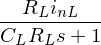

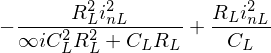

In [54]:
display(RL_noise)
b = symbols("b")
integrate(RL_noise**2, (s, 0, I*b)).subs(b, +oo)

In [69]:
# Problem 2e, find minimum detectable signal power (by re-using the noise expressions with Cgs,CL = 0)
Rs_noise_lowf = Rs_noise.subs(Cgs, 0).subs(CL, 0).subs(vns, sqrt(4*K*T*Rs))
RL_noise_lowf = RL_noise.subs(Cgs, 0).subs(CL, 0).subs(iL, sqrt(4*K*T / RL))
t_noise_lowf = t_noise.subs(Cgs, 0).subs(CL, 0).subs(inoise, sqrt(2*q*Id))

total_noise_lowf = (Rs_noise_lowf**2 + RL_noise_lowf**2 + t_noise_lowf**2).simplify()
print(latex(total_noise_lowf))

\frac{2 R_{L} \left(I_{d} R_{L} q + 2 K R_{L} R_{s} T g_{m}^{2} + 2 K T \left(R_{s} g_{m} + 1\right)^{2}\right)}{\left(R_{s} g_{m} + 1\right)^{2}}


In [ ]:
# Problem 3, Rin
i1,i2,i3 = symbols("i1 i2 i3")
vtest, vx, gm, Rf, ro = symbols("V_{test} V_x g_m R_f r_o")
sol = nonlinsolve([
    i1 - (vtest - vx)/Rf,
    i2 - gm*vtest,
    i3 - (vx / ro),
    i1 - i2 - i3
], [i1, i2, i3, vx, vtest])
display(sol)

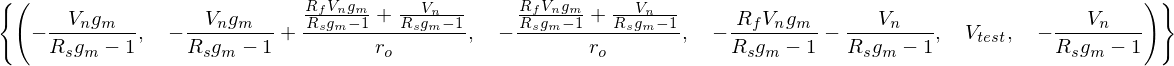

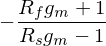

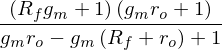

In [50]:
# Problem 3, Rs noise gain
i1,i2,i3 = symbols("i1 i2 i3")
vtest, vx, Vgs, vn, gm, Rf, ro = symbols("V_{test} V_x V_{gs} V_n g_m R_f r_o")
sol = nonlinsolve([
    Vgs - i1*Rs - vn,
    i1 - i2 - i3,
    (vx - Vgs)/Rf - i1,
    i1 - gm*Vgs,
    i3 - vx/ro
], [i1, i2, i3, vx, vtest, Vgs])
display(sol)
Rs_noise_gain = sol.args[0][3] / vn
Rs_noise_gain = Rs_noise_gain.simplify()
Rs_noise_gain_match = Rs_noise_gain.subs(Rs, (ro + Rf) / (1 + ro*gm))
display(Rs_noise_gain)
display(Rs_noise_gain_match.simplify())